# Лирическое вступление

Всем привет! 3 года назад я познакомился с платформой бесплатных онлайн-курсов - ***"Stepik"***

Проблемой многих подобных платформ является то, что ***до конца курсов доходят < 10 % начавших пользователей***

***Важно довести до конца курса как можно больше людей*** по ряду причин: 

1. Некоторые из открытых курсов могут становиться стартовыми площадками для платных, более продвинутых программ. Чем больше людей дойдут до конца, тем больше вероятность выгодной продажи пользователем следующих курсов

2. Количество пользователей, проходящих курс до конца, может выгодно выделять платформу на фоне конкурентов

3. Моральная сторона вопроса: хочется доносить людям знания в полном объеме, а не терять "по дороге" большую часть учеников

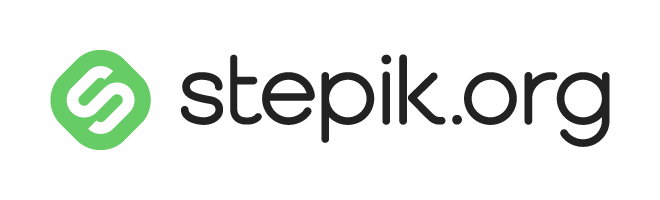

В ходе своего первого учебного проекта в области Data Science я попытаюсь на основе данных с платформы Stepik о поведении пользователей курса "Анализ данных в R" ***выдвинуть предположения о том, почему люди покидают курсы и как можно улучшить ситуацию***

# 1. Анализ и аггрегация данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize' : (9, 6)})

In [102]:
np.random.seed(42)

Загрузим первый набор данных

In [2]:
events_data = pd.read_csv('event_data_train.csv')

В датафрейме ниже собрана информация о взаимодействии пользователей со "степами" - этапами прохождения курса:

1) "step_id" - идентификатор "степа"

2) "timestamp" - время действия (представлено в формате unix-time)

3) "action" - вид действия:
  1. viewed - пользователь просмотрел step
  2. discovered - пользователь разблокировал step
  3. passed - пользователь успешно прошел step
  4. started_attempt - пользователь впервые попытался пройти step
  
4) "user_id" - идентификатор пользователя

In [3]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Для удачного обучения моделей машинного обучения в дальнейшем, необходимо вычленить для каждого пользователя полезные признаки (процент верно решенных степов, количество просмотренных/решенных степов, etc) и уникальную метку - дошел ли этот человек до конца курса. ***Займемся этим***

Приведем время в более привычный для нас вид:

In [4]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [5]:
events_data['day'] = events_data.date.dt.date

In [6]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Посмотрим на число пользователей за первую неделю курса (n days = 7).

P.S. вы можете самостоятельно изменить переменную n с помощью интерактивной полоски

In [7]:
from IPython.display import display
from ipywidgets import FloatSlider

n = 7

fSlider = FloatSlider(
    value=7,
    min=0,     
    max=100.0,  
    step=1, 
    description='n дней:',
    continuous_update=False,  
    orientation='horizontal'
)

def on_value_change(b):
    global n
    n = int(b['new'])
    print('Число дней изменено:')
    print(b['old'], '->', b['new'])

fSlider.observe(on_value_change, names='value')
display(fSlider)

FloatSlider(value=7.0, continuous_update=False, description='n дней:', step=1.0)

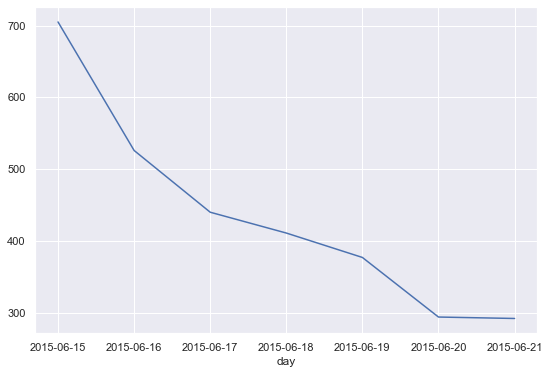

In [8]:
events_data.groupby('day').user_id.nunique()[:n].plot()
None

Посмотрим на распределение количества удачно решенных степов

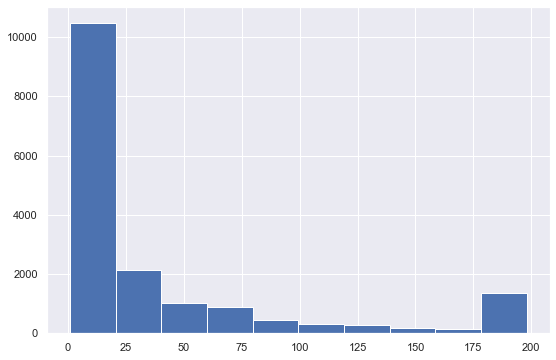

In [9]:
events_data[events_data.action == 'passed'] \
.groupby('user_id', as_index=False).agg({'action' : 'count'}) \
.rename(columns={'action' : 'passed_steps'}).passed_steps.hist()
None

Для каждого пользователя посчитаем число удачно пройденных степов

In [10]:
events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                        fill_value=0).head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


Сохраним эти данные в отдельный датасет

In [11]:
users_events_data = events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                        fill_value=0).reset_index()

users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Теперь у нас есть симпатичная таблица юзеров с статистикой по степам

Установим пороговое значения баллов для получения сертификата

In [12]:
sertificate_value = 170

Укажем для каждого юзера, получил ли он сертификат и сохраним эти данные

In [13]:
check_values = []
for user in users_events_data.passed:
    if user >= sertificate_value:
        check_values.append(True)
    else:
        check_values.append(False)

users_events_data['passed_course'] = check_values

users_events_data.passed_course.value_counts()

False    17801
True      1433
Name: passed_course, dtype: int64

**Лишь 1433 человека из 19234 пытавшихся получили сертификаты и прошли курс до конца**

Приступим к обработке данных о решении юзерами задач курса

Помимо знакомых нам фичей добавилась метка submission_status, показывающая правильно ли (correct) или нет (wrong) пользователь попытался решить задачу данного степа

In [14]:
submissions_data = pd.read_csv('submissions_data_train.csv')

submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Аналогично подработаем время

In [15]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Для каждого юзера посчитаем число верных и проваленных сабмитов и сохраним эти данные в новый датасет

In [16]:
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',
                            fill_value=0).reset_index()

users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Какую паузу в прохождении курса можно считать за слив пользователя?

Соберем информацию о перерывах юзеров при прохождении курса

In [17]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 3600)

gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

Посмотрим на распределение перерывов юзеров в процессе прохождения курса

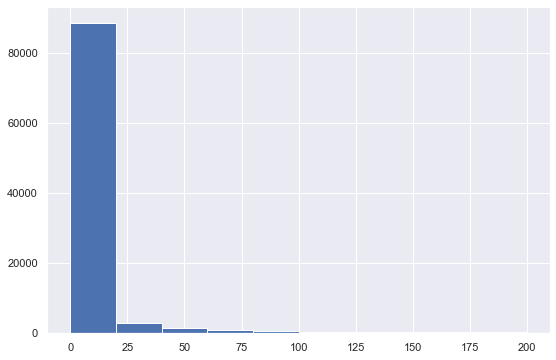

In [18]:
gap_data[gap_data < 200].hist()
None

**Начинаем анализировать, слился ли юзер с курса**

Найдем и сохраним дату последнего посещения курса для каждого пользователя:

"user_id" - идентификатор пользователя

"last_timestamp" - время последнего посещения курса

In [19]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp' : 'max'}).rename(columns={'timestamp' : 'last_timestamp'})

users_data.tail()

,user_id,last_timestamp
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096
19233,26798,1520978742


Введем необходимые переменные:
    
    now - время последнего появления 
    drop_out_threshold - "порог слива". Например, 30 дней

In [20]:
now = 1520978742
drop_out_threshold = 30*24*3600

Если отсутствовал более 30 дней, считаем, что он юзер слился с курса.

Вычислим и сохраним эту ифнормацию

In [21]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,False
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,False


Объединим данные о пользователях воедино

In [22]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,False,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,False,0.0,0.0


In [23]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer')

users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,False
1,2,1519226966,False,2.0,0.0,9,9,2,10,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,False
4,7,1521634660,False,0.0,0.0,1,1,0,1,False


Посчитаем, сколько дней каждый из пользователей провел на курсе

In [24]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


Добавим данные в исходный датафрейм

In [25]:
users_data = users_data.merge(users_days, on='user_id', how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,False,1
1,2,1519226966,False,2.0,0.0,9,9,2,10,False,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,False,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,False,2
4,7,1521634660,False,0.0,0.0,1,1,0,1,False,1


**В среднем для получения сертификата необходимо около 25 дней**

In [26]:
round(users_data[users_data.passed_course].day.mean())

25

Cохраним данные о первом появлении каждого юзера на курсе

In [27]:
user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp' : 'min'}) \
                .rename({'timestamp' : 'min_timestamp'}, axis=1)

Добавим в общий датафрейм

In [28]:
users_data = users_data.merge(user_min_time, how='outer')

Переименуем колонку и получении диплома

In [29]:
users_data = users_data.rename({'diploma' : 'passed_course'}, axis=1)

Взглянем на собранные данные

In [30]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course,day,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,False,1,1472827464
1,2,1519226966,False,2.0,0.0,9,9,2,10,False,2,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,False,7,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,False,2,1466156809
4,7,1521634660,False,0.0,0.0,1,1,0,1,False,1,1521634660


Ключевая задача - попытаться выяснить, уйдет ли пользователь с курса за первые несколько дней

Попробуем сделать это на основании поведения в первые три дня. Соответственно, отберем данные за первые 3 дня. Это можно сделать по-разному, и пошел я не самым стандарным методом

Введем в данные новую фичу "user_time" которая будет хранить в себе значения идентификатора юзера и времени какого-либо его действия

In [31]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [32]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [33]:
days= 3

Пороговое время для n дней

In [34]:
learning_time_threshold = days * 24 * 60 * 60

In [35]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [36]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

Установим пороговое значение времени для каждого юзера

In [37]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


Объединим данные

In [38]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

Проверим, все ли в порядке с разномерностью данных, чтобы ничего не потерять

In [39]:
events_data.shape

(3480703, 8)

Взглянем на предварительно обработанные данные

In [40]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


**Наконец-то, отберем и сохраним данные о первых 3-х днях**

In [41]:
events_data_train = events_data[events_data['user_time'] <= events_data['user_learning_time_threshold']]

Конечно же, взглянем на них

In [42]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Посмотрим на максимально число дней, которое юзер провел на курсе.

В отобранных нами данных это значение не должно превышать трех дней (казалось бы)

In [43]:
events_data_train.groupby('user_id').day.nunique().max()

4

Логично, ведь пользователь мог начать курс, скажем, 15 числа определенного месяца в обед, начит, в нашу таблицу могли попасть и данные о его действиях 16, 17 и 18 числах того же месяца. С 15 по 18 число включительно - 4 дня

Аналогично проведем отбор данных за первые три дня из датафрейма о попытках решения задач

In [44]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

**И снова всё подчиняется логике**

Теперь у нас есть данные за первые три дня, на основании которых мы в дальнейшем попробуем обучить несколько моделей машинного обучения!

Заведем датафрейм для обучения и постепенно будем заполнять его интересными и важными данными

In [45]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename({'day' : 'days'}, axis=1)

Добавили пользователя и число его активных дней за первые 3 дня курса

In [46]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


Добавим туда же число степов, которые пытались пройти юзеры. Заведем новый датафрейм для этого

In [47]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
            .rename({'step_id' : 'steps_tried'}, axis=1)

In [48]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


Объединим его с исходным

In [49]:
X = X.merge(steps_tried, how='outer')

Посмотрим на его размерность, чтобы в дальнейшем сверяться, что мы не теряем данные

In [50]:
X.shape

(8913, 3)

Сохраним число верных субмитов для каждого юзера за первые 3 дня курса

In [51]:
submissions_data_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',
                            fill_value=0).reset_index()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27
...,...,...,...
8908,26787,3,0
8909,26790,1,0
8910,26794,31,9
8911,26797,2,0


Объединим все это дело

In [52]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',
                            fill_value=0).reset_index())

In [53]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


Добавим переменную "correct_ration" - процент верно решенных задач за первые 3 дня курса

In [54]:
X['correct_ration'] = X['correct'] / (X['correct'] + X['wrong'])

In [55]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ration
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


Посчитаем число просмотренных степов для каждого пользователя

In [56]:
X = X.merge(events_data_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                            fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

Взглянем на промежуточные данные

In [57]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ration,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


Контролируем, не произошло ли потери данных

In [58]:
X.shape

(19234, 7)

Заполним пустые ячейки нулями (например, у пользователя не было попыток решения в первые 3 дня)

In [59]:
X = X.fillna(0)

In [60]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course,day,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,False,1,1472827464
1,2,1519226966,False,2.0,0.0,9,9,2,10,False,2,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,False,7,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,False,2,1466156809
4,7,1521634660,False,0.0,0.0,1,1,0,1,False,1,1521634660


Временно расширим датафрейм X

In [61]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

Взглянем на данные

In [62]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ration,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,False
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Для обучения моделей выбросим "непонятных" юзеров, которые еще не прошли курс, но и не бросили его.

Оставим тех, кто либо уже прошел курс, либо уже бросил его

In [63]:
X = X[(X.is_gone_user)|(X.passed_course)]

Взглянем на даные

In [64]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ration,viewed,passed_course,is_gone_user
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
5,17,1.0,1.0,0.0,2.0,0.00,13,False,True


In [65]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            14713
True           False             374
               True             1059
Name: user_id, dtype: int64

**14713** пользователей ушли с курса

**1059** уже прошли его и "вышли" с курса

**374** человек уже прошли его, но почему-то еще не ушли с курса (вероятно, они закончили его совсем недавно)

Также сохраним вектор с целевой переменной, ушел ли юзер с курса, для обучения моделей

In [66]:
y = X.passed_course.map(int)

Уберем лишние колонки и изменим индекс в датафрейме с фичами о юзерах

In [67]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [68]:
X = X.set_index('user_id')

Проверим, совпадают ли размерности 

In [69]:
X.shape

(16146, 6)

In [70]:
y.shape

(16146,)

# 2. Обучение моделей

На данном этапе необходимо получить 2 качественные модели:

***Первая*** будет помогать за первые n дней (в нашем случае, n=3) определять пользователей, которые потенциально могут покинуть курс раньше времени

***Вторая*** "покажет" нам, какие из признаков наиболее показательны для того, чтобы сказать, покинет ли пользователь курс досрочно. С ее помощью я выдвину гипотезы о том, как можно повлиять на поведение пользователей

Для определения качества работы моделей ***мы будем использовать метрику recall***

***Почему именно recall?***

1. Наша выборка не сбалансированна (количество досрочно покинувших курс пользователей куда больше количества дошедших до конца),  соответственно, судить модель по проценту верных ответов неправильно (модель может постоянно говорить, что пользователь покинет курс, и будет права ~ в 90 % случаев, но обучаться не станет)

2. Высокий recall - признак того, что мы упустили минимум человек, которые могут уйти - а именно этого мы и добиваемся. Мы не хотим пропустить ни одного "сливающегося", потому что стремимся довести до конца каждого

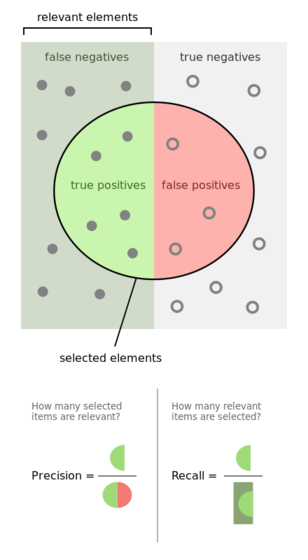

Импортируем необходимые библиотеки

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

Создадим функцию, c помощью которой будем считать значение recall'a и вспомогательную к ней функцию rnd

Чтобы параллельно отслеживать значение precision (слишком низкий precision плох, т.к. мы не хотим совершать слишком много ложных движений)

***Поставим задачу***:

***recall >= 0.7 и precision >= 0.3***

Attention: функция rnd принимает значение порога threshold. Чем больше порог - тем более ярко выраженных потенциальных "беженцев" будут выделять алгоритмы. С этим порогом я экспериментировал. В финальной версии вы видите оптимальный порог.  

In [141]:
def rnd(x, threshold=0.15):
    if x > threshold:
        return 1
    return 0

In [142]:
def recall(model, data, labels):
    pred = np.array(list(map(rnd, model.predict(data))))
    return recall_score(labels, pred)

In [143]:
def precision(model, data, labels):
    pred = np.array(list(map(rnd, model.predict(data))))
    return precision_score(labels, pred)

**Для начала обучим простейшую логистическую регрессию**

In [144]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

***Нормализуем данные***

In [145]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler()
transformer.fit(X_train)
X_train_scaled = transformer.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

transformer.fit(X_test)
X_test_scaled = transformer.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

***Обучим простую регресиию на нормализованных данных***

In [146]:
from sklearn.linear_model import LogisticRegression

regressor = LogisticRegression()

regressor.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

***Заведем словарь для хранения лучших показателей каждой модели***

In [147]:
results = {}

***Посмотрим на качество работы простейшей регрессии***

In [148]:
regressor_recall = recall(regressor, X_test_scaled, y_test)
regressor_precision = precision(regressor, X_test_scaled, y_test)
results['log_reg'] = {}
results['log_reg']['recall'] = regressor_recall
results['log_reg']['precision'] = regressor_recall

print(f"Recall простой регрессии с нормализацией данных - {round(regressor_recall, 4)}")
print(f"Precision простой регрессии с нормализацией данных - {round(regressor_precision, 4)}")

Recall простой регрессии с нормализацией данных - 0.1715
Precision простой регрессии с нормализацией данных - 0.5663


***Попробуем сделать то же самое без нормализации***

In [149]:
# получили результаты лучше, поэтому пересохраняем

regressor.fit(X_train, y_train)

scaled_regressor_recall = recall(regressor, X_test, y_test)
scaled_regressor_precision = precision(regressor, X_test, y_test)
results['log_reg']['recall'] = scaled_regressor_recall
results['log_reg']['precision'] = scaled_regressor_precision

print(f"Recall простой регрессии без нормализации данных - {round(scaled_regressor_recall, 4)}")
print(f"Precision простой регрессии без нормализации данных - {round(scaled_regressor_precision, 4)}")

Recall простой регрессии без нормализации данных - 0.1788
Precision простой регрессии без нормализации данных - 0.5698


***Дополнительно объяснение, почему нам важен recall:***

Нам важно допускать меньше False Negative ошибок, так как в таком случае мы рискуем не определить потенциально сливающегося пользователя

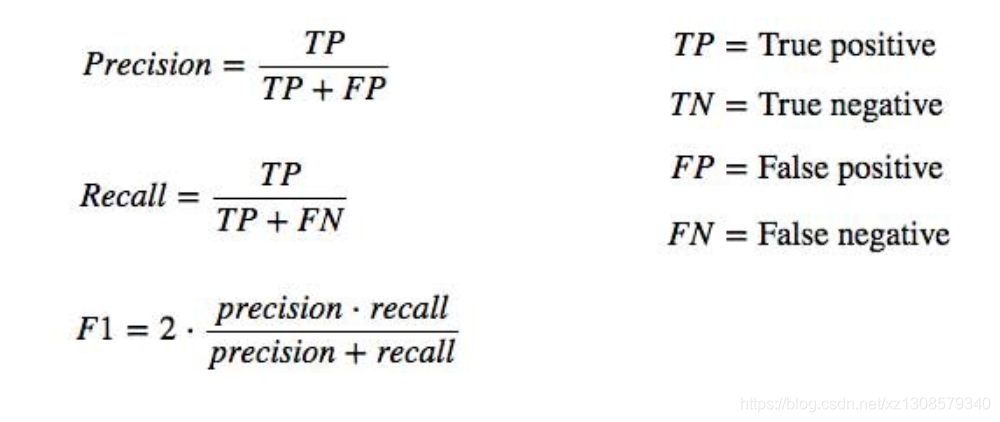

***Посмотрим и интерпертируем веса получившейся логистической регрессии***

In [150]:
regressor.fit(X_train, y_train)
features = list(X_train)
coeffs = regressor.coef_[0]
bias = regressor.intercept_[0]

In [151]:
for feature, weight in zip(features, coeffs):
    print(f'{feature}:  {round(weight, 4)}')
print(f'bias: {round(bias, 4)}')

days:  0.6051
steps_tried:  -0.0456
correct:  0.1079
wrong:  0.0047
correct_ration:  0.9577
viewed:  -0.0005
bias: -3.9325


Нибольшее влияние на поведение пользователей оказывают:

1. Количество дней, в течение которого ***пользователь совершал какие-либо действия***

2. Количество ***верно решенных*** степов 

Варианты влиять на них:

1. СИЛЬНАЯ АГИТАЦИЯ К УЧАСТИЮ НА В ПЕРВЫЕ НЕСКОЛЬКО ДНЕЙ (В НАШЕМ СЛУЧАЕ, ТРЕХ)

2. ДОПОЛНИТЕЛЬНЫЕ ЗАДАЧИ ПОПРОЩЕ, КОТИКИ ПРИ ВЕРНЫХ РЕШЕНИЯХ, ГИПЕРССЫЛКИ К ТЕОРЕТИИ, ССЫЛКИ НА ПОХОЖИЕ ЗАДАЧИ

Обучим регрессии с регуляризациями

In [152]:
from sklearn.linear_model import Ridge, Lasso

***Ridge-регрессия***

In [153]:
ridge = Ridge()

По опыту обычной регрессии будем сразу обучать на не нормализованных данных

In [154]:
ridge.fit(X_train, y_train)

ridge_recall =  recall(ridge, X_test, y_test)
ridge_precision = precision(ridge, X_test, y_test)

print(f"Recall ridge-регрессии без нормализации данных - {round(ridge_recall, 4)}")
print(f"Precision ridge-регрессии без нормализации данных - {round(ridge_precision, 4)}")

Recall ridge-регрессии без нормализации данных - 0.6934
Precision ridge-регрессии без нормализации данных - 0.2905


Ridge-регрессия, использующая l2-регуляризацию позволила нам вполтную приблизиться к поставленной задаче

Сохраним получившиеся результаты

In [157]:
results['ridge_reg'] = {}
results['ridge_reg']['recall'] = ridge_recall
results['ridge_reg']['precision'] = ridge_precision

In [158]:
results

{'log_reg': {'recall': 0.17883211678832117, 'precision': 0.5697674418604651},
 'ridge_reg': {'recall': 0.6934306569343066, 'precision': 0.290519877675841}}

***Lasso-регрессия***

In [120]:
lasso = Lasso(alpha=0.1)

In [159]:
lasso.fit(X_train, y_train)

lasso_recall = recall(lasso, X_test, y_test)
lasso_precision = precision(lasso, X_test, y_test)

print(f"Recall lasso-регрессии без нормализации данных - {round(lasso_recall, 4)}")
print(f"Precision lasso-регрессии без нормализации данных - {round(lasso_precision, 4)}")

Recall lasso-регрессии без нормализации данных - 0.635
Precision lasso-регрессии без нормализации данных - 0.3026


Сохраним получившееся значение

In [160]:
results['lasso_reg'] = {}
results['lasso_reg']['recall'] = lasso_recall
results['lasso_reg']['precision'] = lasso_precision

# Пробуем ансамблевые методы

Начнем с рандомного леса

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Подберем гиперпараметры 

In [178]:
params = {
        'max_depth': [3, 4, 5],
        'n_estimators': [100, 200, 300, 500]
        }

In [179]:
forest = RandomForestClassifier()
grid_forest = GridSearchCV(forest, params, n_jobs=-1)

In [180]:
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

"Вытащим" лучший лес

In [181]:
best_forest = grid_forest.best_estimator_

In [182]:
forest_recall = recall(best_forest, X_test, y_test)
forest_precision = precision(best_forest, X_test, y_test)

print(f"Recall леса без нормализации данных - {round(forest_recall, 4)}")
print(f"Precision леса без нормализации данных - {round(forest_precision, 4)}")

Recall леса без нормализации данных - 0.0657
Precision леса без нормализации данных - 0.6429


Ощущение, что recall и precision поменялись местами :)

Видимо, лес - не лучший алгоритм для нашей задачи

Так или иначе, сохраним результат

In [195]:
results['forest'] = {}
results['forest']['recall'] = forest_recall
results['forest']['precision'] = forest_precision

Посмотрим на подобранные для леса параметры

In [200]:
for name, value in grid_forest.best_params_.items():
    print(f'{name} -- {value}')

max_depth -- 3
n_estimators -- 300


Пробуем градиентный бустинг

In [125]:
from xgboost import XGBClassifier

Создадим основные гиперпараметры для подбора

In [188]:
params = {
        'gamma': [0.1, 0.2],
        'max_depth': [3, 4, 5],
        'n_estimators': [100, 200, 300, 500],
        'min_child_weight': [0.5, 2, 5]
        }

Создадим модель

In [126]:
xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic',
                    silent=True, nthread=1)

Создадим сеточку, обучим ее и сохраним лучшую модель

In [189]:
grid = GridSearchCV(xgb, params, n_jobs=-1)

In [190]:
grid.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:47:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:47:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     reg_lambda=None, scale_pos_weight=None,
                                     silent=True, subsample=None,
                                     tree_method=None, use_label_encoder=True,
                                     validate_parameters=None

Сохраним подобранную модель

In [192]:
best_xgb = grid.best_estimator_

Посмотрим на параметры подобранного ансамбля

In [201]:
for name, value in grid.best_params_.items():
    print(f'{name} -- {value}')

gamma -- 0.2
max_depth -- 5
min_child_weight -- 0.5
n_estimators -- 200


Посчитаем и сохраним метрики

In [202]:
xgb_recall = recall(best_xgb, X_test, y_test)
xgb_precision = precision(best_xgb, X_test, y_test)

print(f'Recall градиентного бустинга: {xgb_recall}')
print(f'Precision градиентного бустинга: {xgb_precision}')

Recall градиентного бустинга: 0.13138686131386862
Precision градиентного бустинга: 0.5070422535211268


In [204]:
results['xgb'] = {}
results['xgb']['recall'] = xgb_recall
results['xgb']['precision'] = xgb_precision

# 3. Подведем итоги

Для удобства переделаем всё в датафрейм

In [205]:
import pandas as pd

In [206]:
res = pd.DataFrame(index=['log_reg', 'ridge_reg', 'lasso_reg', 'forest', 'xgb'],
                  columns=['recall', 'precision'])

In [210]:
res

,recall,precision
log_reg,NaN,NaN
ridge_reg,NaN,NaN
lasso_reg,NaN,NaN
forest,NaN,NaN
xgb,NaN,NaN


In [224]:
res['recall'] = results['log_reg']['recall'], results['ridge_reg']['recall'], results['lasso_reg']['recall'], results['forest']['recall'], results['xgb']['recall']
res['precision'] = results['log_reg']['precision'], results['ridge_reg']['precision'], results['lasso_reg']['precision'], results['forest']['precision'], results['xgb']['precision']

In [226]:
res

,recall,precision
log_reg,0.178832,0.569767
ridge_reg,0.693431,0.290520
lasso_reg,0.635036,0.302609
forest,0.065693,0.642857
xgb,0.131387,0.507042


***Выводы***

1. Даже не осуществляя запросов к датафрейму, очевидно, что лучше всего себя показал алгоритм Ridge-регрессии, который максимально приблизил нас к поставленным числам. 

2. Почему-то на линейых моделях негативно сказалась нормализация данных

3. Некоторые из алгоритмов показали precision сильно превышающий recall. Мы же первостепенно обратили внимание на recall

Интерпретируя веса линейных моделей, наибольшее влияние на поведение пользователей оказывают:

1. Количество дней, в течение которого ***пользователь совершал какие-либо действия***

2. Количество ***верно решенных*** степов 

Интерпретируя веса lasso-регрессии, которая за счет l1-регуляризации способна указать на "неважные" признаки, на поведение пользователя практически не оказывают влияние:

1. Количество просмотренных степов

2. Количество неверное решенных задач (что мне кажется странным)

3. Количество степов, которые пробовал решить пользователей

ML алгоритмы для данной задачи можно улучшать, за первые N дней курсу успешно классифицируя пользователей, которые могут отвалиться в процессе обучения. Интерпретация весов позволяет узнать, как мы можем воздействовать на пользователя: давать ему дополнительные задачки, выводить милые картинки для поднятия боевого духа, делать ссылки на теоретический материал.

Однако вопрос остается открытым)

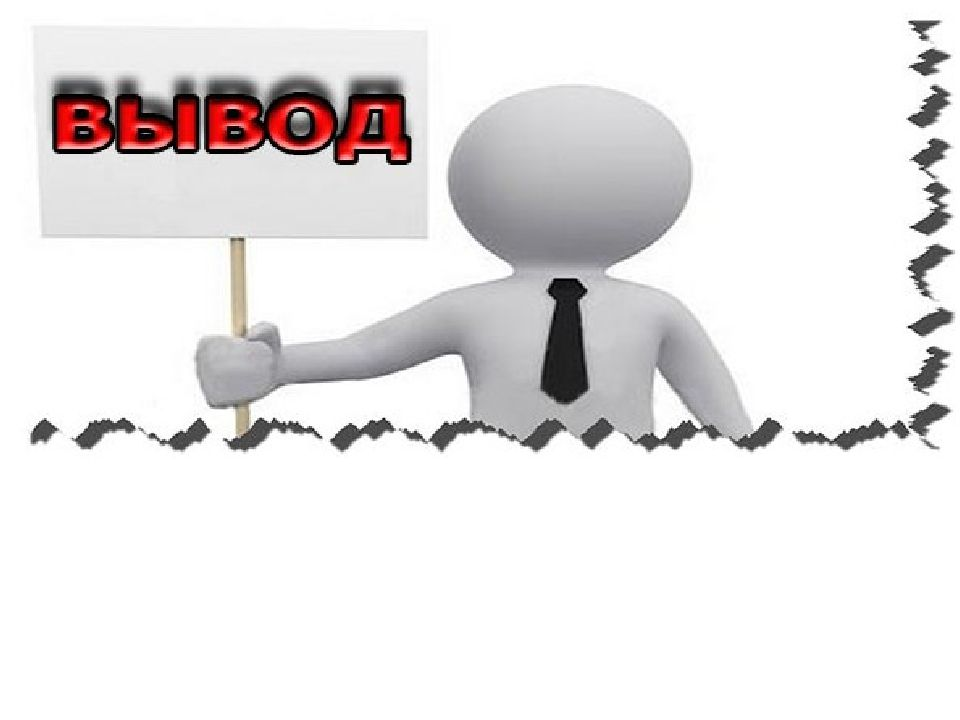